# Translating Sentences From Italian to English with FNet

>Transformer FNet model trained on over 300 000 examples to translate sentences from Italian to English. Model was trained using Google Colab free GPU for 13 epochs on train dataset (size: 246 632) and then fine-tuned with learning rate reduced tenfold on validation dataset (size: 52850). Model losses before and after fine-tuning are presented in the table below. Digits indicate number of epochs during fine-tuning.


|  | train | train+val 2 | train+val 3 | train+val 4 | train+val 6 |
| --- | --- | --- | --- | --- | --- |
| **Loss** | 0.2363 | 0.2032 | 0.2012 | **0.2009** | 0.2019 |


> Since self-attention layer is replaced with Fourier Transform in Encoder part of the model total training time is reduced by ~80%. Despite haveing less parameters Fnet is able to achieve ~90% of *regular* Transofrmer's accuracy. Training time in total took around 1.5h. Model is also a bit overfitting, solution may be to reduce model size, further implement regularization or get some more data.

> Later model was evaluated with BLEU metric, but since translating entire test set (size: 52850) takes long time, only random 10 000 sentences were chosen and evaluated. BLEU score for selected sentences was 0.77 which is surprisingly high :V <br> 
The answer may be that there are many short sentences which are easy to predict with such model.

### FNet Architecture

In [1]:
import keras
import keras.backend as K
from keras import layers
import tensorflow as tf
import tensorflow.data
from keras.utils import plot_model


from nltk.translate import bleu_score
from sklearn.model_selection import train_test_split
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


# disable warnings for nltk BLEU
import warnings
warnings.filterwarnings("ignore")

In [2]:
class EmbeddingsConfig:
    
    embedding_dim = 128 # 256
    vocab_size = 10000
    maxlen = 20

In [3]:
class Embeddings(layers.Layer):
    
    def __init__(self, config, **kwargs):
        super(Embeddings, self).__init__(**kwargs)
        
        self.embedding_dim = config.embedding_dim
        self.maxlen = config.maxlen
        self.vocab_size = config.vocab_size
        
        self.position_embeddings = layers.Embedding(
            input_dim=config.maxlen,
            output_dim=config.embedding_dim
        )
        
        self.token_embeddings = layers.Embedding(
            input_dim=config.vocab_size,
            output_dim=config.embedding_dim
        )
        
        
    def call(self, x):
        positions = K.arange(start=0, stop=self.maxlen, step=1)
        positions = self.position_embeddings(positions)
        x = self.token_embeddings(x)
        return x + positions
    
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    
    def __str__(self):
        return 'Embeddings'

In [4]:
class TransformerConfig:
    
    embedding_dim = 128 #256
    dense_dim = 256 #512
    num_heads = 8 # 6
    dropout = 0.5

In [5]:
class FNetEncoder(layers.Layer):
    
    def __init__(self, config, **kwargs):
        super(FNetEncoder, self).__init__(**kwargs)
        
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(units=config.dense_dim, activation='relu'),
                layers.Dense(units=config.embedding_dim)
            ]
        )
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        
        
    def call(self, x):
        
        fourier = tf.signal.fft2d(tf.cast(x, tf.complex64))
        real = tf.math.real(fourier)
    
        residual = self.norm1(real + x)
        ffnn = self.dense_proj(residual)
        return self.norm2(residual + ffnn)
    
    
    def __str__(self):
        return 'FNetEncoder'

In [6]:
class Decoder(layers.Layer):
    
    def __init__(self, config, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(config.dropout)
        self.dropout2 = layers.Dropout(config.dropout)
        self.supports_masking = True
        
        self.attention1 = layers.MultiHeadAttention(
            num_heads=config.num_heads,
            key_dim=config.embedding_dim,
            name='att_1'
        )
        
        self.attention2 = layers.MultiHeadAttention(
            num_heads=config.num_heads,
            key_dim=config.embedding_dim,
            name='att_2'
        )
        
        self.dense_proj = keras.Sequential(
        [
            layers.Dense(units=config.dense_dim, activation='relu'),
            layers.Dense(units=config.embedding_dim)
        ])
        
        
    def call(self, x, enc_out, mask=None):
        casual_mask = self.get_casual_mask(x)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, casual_mask)
        
        attention1 = self.attention1(
            query=x, 
            key=x, 
            value=x, 
            attention_mask=casual_mask
        )
        
        residual1 = self.dropout1(attention1)
        residual1 = self.norm1(x + attention1)
        attention2 = self.attention2(
            query=residual1,
            key=enc_out,
            value=enc_out,
            attention_mask=padding_mask
        )
        
        residual2 = self.norm2(residual1 + attention2)
        ffnn = self.dense_proj(residual2)
        ffnn = self.dropout2(ffnn)
        return self.norm3(residual2 + ffnn)
    
    
    
    def get_casual_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    
    
    def __str__(self):
        return 'Decoder'

In [7]:
transformer_conf = TransformerConfig()
embeddings_conf = EmbeddingsConfig()

In [8]:
def connect_model():
    enc_inputs = layers.Input(shape=(None, ), name='encoder_inputs')
    x = Embeddings(embeddings_conf)(enc_inputs)
    enc_out = FNetEncoder(transformer_conf)(x)

    dec_inputs = layers.Input(shape=(None, ), name='decoder_inputs')
    dec_state_inputs = layers.Input(shape=(None, embeddings_conf.embedding_dim), name='decoder_state_inputs')

    x = Embeddings(embeddings_conf)(dec_inputs)
    x = Decoder(transformer_conf)(x, dec_state_inputs)
    x = layers.Dropout(0.5)(x)
    dec_outputs = layers.Dense(embeddings_conf.vocab_size, activation='softmax', name='decoder_outputs')(x)

    decoder = keras.Model([dec_inputs, dec_state_inputs], dec_outputs)
    decoder_outputs = decoder([dec_inputs, enc_out])
    model = keras.Model([enc_inputs, dec_inputs], decoder_outputs, name='fnet')
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return model


model = connect_model()

In [20]:
model.summary()

Model: "fnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embeddings (Embeddings)         (None, 20, 128)      1282560     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
f_net_encoder (FNetEncoder)     (None, 20, 128)      66432       embeddings[0][0]                 
_______________________________________________________________________________________________

In [9]:
def load_dataset(path):
    name = path.split('/')[-1]
    with open(f'{path}/{name}.pkl', 'rb') as file:
        spec = pkl.load(file)
        
    dataset = tensorflow.data.experimental.load(path, element_spec=spec)
    return dataset

In [66]:
path = '../Data/italian/'
train_ds = load_dataset(path+'train_ds')
val_ds = load_dataset(path+'val_ds')

In [67]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, verbose=1, monitor='val_loss')
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, save_weights_only=True)

In [ ]:
# training done in Google Colab
# after 13 epochs early stopping 
# model trained for around 1.5h
his = model.fit(train_ds,
                validation_data=val_ds,
                epochs=30,
                shuffle=True,
                callbacks=[early_stopping, model_checkpoint])

### Inference

In [70]:
with open('../Models/ok/training.pkl', 'rb') as file:
    training_result = pkl.load(file)

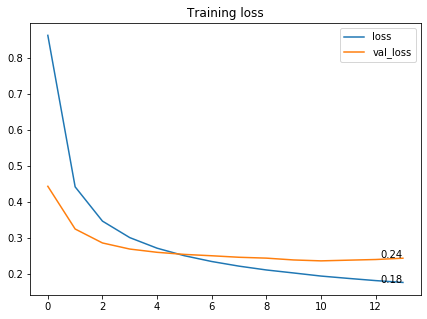

In [71]:
def mark_last_element(ax, arr):
    x = len(arr)-1
    y = arr[-1]
    ax.text(x, y, round(arr[-1], 2), ha='right')

fig = plt.figure(figsize=(7, 5))
plt.plot(training_result['loss'], label='loss')
plt.plot(training_result['val_loss'], label='val_loss')

mark_last_element(fig.get_axes()[0], training_result['loss'])
mark_last_element(fig.get_axes()[0], training_result['val_loss'])

plt.title('Training loss')
plt.legend()
plt.show()

In [12]:
def load_vectorizer(path):
    with open(path, 'rb') as file:
        config = pkl.load(file)
    vec = layers.experimental.preprocessing.TextVectorization.from_config(config['config'])
    # bugged so I have to adapt on dummy data
    vec.adapt(['dummy'])
    vec.set_weights(config['weights'])
    return vec

In [13]:
def convert_back_from_tokens(vectorizer, tokens):
    # not efficient af and probably also not safe
    token_dict = {k:v for k, v in list(enumerate(vectorizer.get_vocabulary()))}
    result = ''
    if not isinstance(tokens, np.ndarray):
        tokens = tokens.numpy()
    for i in tokens:
        # start and end tokens
        if i == 2 or i == 3:
            continue
        # pad token
        elif i == 0:
            break
        result += token_dict[i] + ' '
        
    # remove redundant space
    return result[:-1]


# check if it works
# print('INPUT:\t', convert_back_from_tokens(eng_vec, ytest[0]))
# print('TARGET:\t', convert_back_from_tokens(ita_vec, xtest[0]))

In [14]:
# load vectorizers
eng_vec = load_vectorizer('../Vectorizers/vec_eng.pkl')
ita_vec = load_vectorizer('../Vectorizers/vec_ita.pkl')

# load weights
model.load_weights('../Models/fine-tuned/weights-fine-tuned-4.h5')

# load test_ds and test_pkl
test_ds = load_dataset('../Data/italian/test_ds')

with open('../Data/italian/test.pkl', 'rb') as file:
    test = pkl.load(file)
    xtest = test[0]['encoder_inputs']
    ytest = test[1]

In [119]:
# trained on train_ds and  fine tuned on val_ds (4 epochs)
loss = model.evaluate(test_ds, verbose=2)
print('loss on test_ds: ', round(loss, 3))

loss on test_ds:  0.201


In [15]:
def translate_sentence(sentence):
    encoder_input = ita_vec([sentence])
    decoder_input = eng_vec(['ssss'])[:, :-1].numpy()
    
    for i in range(embeddings_conf.maxlen):
        probs = model.predict({'encoder_inputs': encoder_input, 
                              'decoder_inputs': decoder_input})
        token = np.argmax(probs[:, i, :])
        if token == 3: # eeee
            break
        try:
            decoder_input[:, i+1] = token
        except IndexError: 
            break
    return convert_back_from_tokens(eng_vec, decoder_input[0])


# check check
translate_sentence('Le porte sono state aperte')

'the doors have been open'

In [16]:
def compare_sentences(sentence, actual_translation, calculate_bleu=True):
    translated_sentence = translate_sentence(sentence)
    print('ORIGINAL:\t', sentence)
    print('TRANSLATED:\t', translated_sentence)
    print('ACTUAL:\t\t', actual_translation)
    if calculate_bleu == True:
        # BLEU 1-4 metric
        weights = [[1.0/i for x in range(i)] for i in range(1, 5)]
        scores = [
            bleu_score.sentence_bleu([actual_translation.split()], translated_sentence.split(), weights=w)
            for w in weights
        ]
        scores = list(map(lambda x: round(x, 2), scores))
        print('BLEU{1-4}:\t', *scores)

        
# check if it works
compare_sentences('Le porte sono state aperte', 'The doors have been opened')

ORIGINAL:	 Le porte sono state aperte
TRANSLATED:	 the doors have been open
ACTUAL:		 The doors have been opened
BLEU{1-4}:	 0.6 0.55 0.46 0.0


In [17]:
# convert list of tokens to list of strings 
def convert_all(x, y):
    X = [convert_back_from_tokens(ita_vec, tokens) for tokens in x]
    Y = [convert_back_from_tokens(eng_vec, tokens) for tokens in y]
    return X, Y

In [120]:
# convert back 100 samples from test 
# and pick random 10 just to see the overall result
input_sentences, target_sentences = convert_all(xtest[:100], ytest[:100])

amount = 10
indexes = np.random.randint(0, len(input_sentences), size=amount)
for i in indexes:
    compare_sentences(input_sentences[i], target_sentences[i])
    print()

ORIGINAL:	 lha detto
TRANSLATED:	 did you say that
ACTUAL:		 did she say it
BLEU{1-4}:	 0.5 0.0 0.0 0.0

ORIGINAL:	 io sono [UNK]
TRANSLATED:	 im a trainee
ACTUAL:		 im busy as a bee
BLEU{1-4}:	 0.34 0.0 0.0 0.0

ORIGINAL:	 solitamente sono a casa il lunedì pomeriggio
TRANSLATED:	 i usually go home on mondays
ACTUAL:		 im usually at home monday afternoons
BLEU{1-4}:	 0.33 0.0 0.0 0.0

ORIGINAL:	 ho incontrato in biblioteca lunedì
TRANSLATED:	 i met in the library on monday
ACTUAL:		 i met tom in the library on monday
BLEU{1-4}:	 0.87 0.79 0.69 0.61

ORIGINAL:	 sta ancora dormendo
TRANSLATED:	 are you still sleeping
ACTUAL:		 tom is still asleep
BLEU{1-4}:	 0.25 0.0 0.0 0.0

ORIGINAL:	 possiamo aver fatto un errore
TRANSLATED:	 we can make a mistake
ACTUAL:		 we may have made a mistake
BLEU{1-4}:	 0.49 0.32 0.0 0.0

ORIGINAL:	 [UNK] la finestra
TRANSLATED:	 they [UNK] the window
ACTUAL:		 lets open the window
BLEU{1-4}:	 0.5 0.41 0.0 0.0

ORIGINAL:	 dovrebbe [UNK]
TRANSLATED:	 you shoul

In [164]:
# takes a long, long time to execute 
# so i'll store it in a .txt file
# all_inputs, all_targets = convert_all(xtest, ytest)

# with open('../Temp/sentence_pairs.txt', 'w', encoding='utf-8') as file:
#     for x, y in zip(all_inputs, all_targets):
#         file.write(f'{x}\t{y}\n')

In [18]:
with open('../Temp/sentence_pairs.txt', 'r', encoding='utf-8') as file:
    all_inputs, all_targets = [], []
    for line in file.readlines():
        inp, trg = line.strip('\n').split('\t')
        all_inputs.append(inp)
        all_targets.append([trg])

In [19]:
# since translating entire test set is expensive 
# I will pick 10 000 random sentences, translate and calculate BLUE 
amount = 10000
indexes = np.random.randint(0, len(all_inputs), size=amount)

translated_sentences = [translate_sentence(all_inputs[i]) for i in tqdm(indexes)]
actual_sentences = [all_targets[i] for i in indexes]

In [21]:
bleu = bleu_score.corpus_bleu(actual_sentences, translated_sentences)
print(f'BLEU score for {amount} samples is: {round(bleu, 2)}')

BLEU score for 10000 samples is: 0.77
